# 数据优化

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import os

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

In [25]:
!conda activate geo
!conda install -c conda-forge jupyterlab-lsp

^C


## 数据批量读取

In [3]:
from_path = r"E:\Netease\智慧城市\4.处理数据\workingdata3"
to_path = r"E:\Netease\智慧城市\4.处理数据\workingdata4"

triptype_lst = ["越野跑","滑翔伞","crosscountry","观光旅行","其他","Gps作画","骑行","徒步","山地骑行","跑步","摩托车","寻宝","自驾车","滑雪","摄影","登山"]
d_dic = {"徒步":0.1,
    "越野跑":0.2,"跑步":0.2,
    "自驾车":1,
    "摩托车":1,
    "其他":1,
    "登山":0.1,
    "观光旅行":0.1,
    "骑行":0.2,"山地骑行":0.2}

## 数据批量优化

In [3]:
from math import radians,sin,cos,asin,sqrt
def geodistance(lng1,lat1,lng2,lat2):         #【☆】计算两坐标点之间的距离函数（单位：km）
    lng1, lat1, lng2, lat2 = map(radians, [lng1, lat1, lng2, lat2]) # 经纬度转换成弧度
    dlon=lng2-lng1
    dlat=lat2-lat1
    a=sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2 
    distance=2*asin(sqrt(a))*6371*1000 # 地球平均半径，6371km
    distance=round(distance/1000,3)
    return distance

def func(dataframe):
    try:
        tmp_df = dataframe[['FID', 'tripid', 'geometry']]
        FID,tripid,geometry = tmp_df.values[0]
        ans = []
        points = geometry.coords[:] # 线转点
        dist = [geodistance(o[0],o[1],d[0],d[1]) for o,d in zip(points,points[1:])]+[float('inf')]
        tmp = []
        for i,d in enumerate(dist):
            tmp.append(points[i])
            if d> d_dic[triptype]:         # 【修改处2】 这里输入两点距离的阈值，不同出行类型的阈值详见“清洗流程.doc”
                if len(tmp)>1:
                    ans.append([FID, tripid,LineString(tmp)])
                tmp=[]
        return pd.DataFrame(ans,columns=['FID','tripid','geometry'])
    except Exception as e:
        print(e.args)
        print(dataframe)

In [4]:
for triptype in d_dic.keys():
    df = gpd.read_file(from_path+r'\track_{}.shp'.format(triptype))
    df["FID"] = df["level_1"]
    
    df_clean = df.groupby('tripid').apply(func)
    df_clean = df_clean.reset_index(drop=True)
    df_clean = gpd.GeoDataFrame(df_clean)
    print(triptype,len(df_clean))
    df_clean.to_file(os.path.join(to_path,"track_{}_clean.shp".format(triptype)))

徒步 6782
越野跑 108
自驾车 1182
摩托车 74
其他 352
登山 12309
观光旅行 9561
骑行 1185
山地骑行 629


跑步 357

## 查看数据

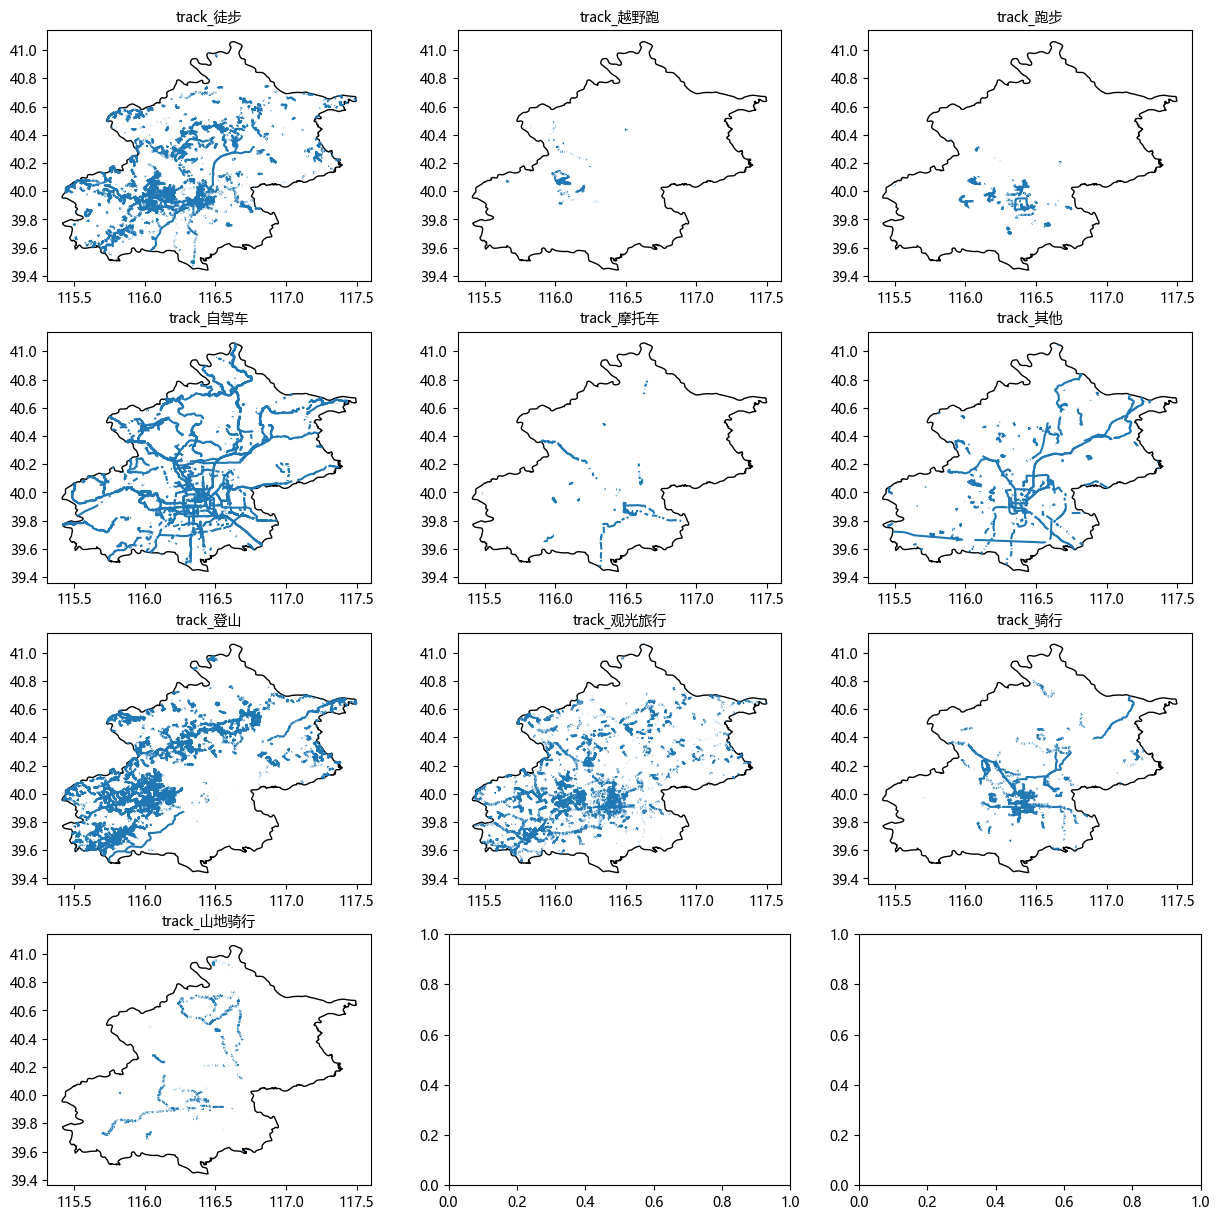

In [16]:
#### 合并数据查看
x_size,y_size = [4,3]
fig,axes = plt.subplots(x_size,y_size,figsize=(15,15))
df_bj = gpd.read_file(r"E:\Netease\智慧城市\4.处理数据\rawdata\北京市行政边界.shp")

for n,triptype in enumerate(d_dic.keys()):
    # 绘制北京市边界
    df_bj.plot(ax=axes[n//y_size,n%y_size],color="none",legend=False)

    # 增绘轨迹位置
    df_clean = gpd.read_file(os.path.join(to_path,"track_{}_clean.shp".format(triptype)))
    df_clean.plot(ax=axes[n//y_size,n%y_size])

    # 设置标题
    axes[n//y_size,n%y_size].set_title("track_{}".format(triptype),fontsize=10)

plt.show()

In [23]:
plt.savefig("E:\\Netease\\智慧城市\\4.处理数据\\outputs\\分类清洗后图片.png")

<Figure size 640x480 with 0 Axes>

In [13]:
df_clean

,FID,tripid,geometry
0,0,121791,"LINESTRING (116.04937 39.73721, 116.04865 39.7..."
1,0,121791,"LINESTRING (116.03622 39.72462, 116.03625 39.7..."
2,0,121791,"LINESTRING (116.01450 39.71517, 116.01449 39.7..."
3,0,121791,"LINESTRING (116.01550 39.70073, 116.01564 39.6..."
4,0,121791,"LINESTRING (116.01586 39.69784, 116.01604 39.6..."
...,...,...,...
624,0,912922,"LINESTRING (116.56545 40.93332, 116.56644 40.9..."
625,0,912922,"LINESTRING (116.59101 40.92542, 116.59264 40.9..."
626,0,912922,"LINESTRING (116.59802 40.92267, 116.59868 40.9..."
627,0,912922,"LINESTRING (116.60526 40.91636, 116.60524 40.9..."
